In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [2]:
# get model path
model_name = 'SpikeResnet'
path_model = os.path.join('..','Backstage',model_name)
# frequency of the data used in the model
FQ = 128

In [3]:
# get prediction dataframe from Backstage/Model_name
bonobo_pred = pd.read_csv(path_model+'/bonobo_pred.csv')
bonobo_pred = pd.read_csv(path_model+'/93.7_predictions.csv')

# get labels dataframe from Judge
path_bonobo_labels = os.path.join('..','Judge','testset_bonobo_events.csv')
bonobo_labels = pd.read_csv(path_bonobo_labels)
# get list of control eegs 
path_controls = os.path.join('..','Judge','testset_controls.csv')
controls = pd.read_csv(path_controls)


In [4]:
# add prediction of event file to labels
bonobo_all = bonobo_labels.merge(bonobo_pred, on='event_file', how='left')

# only look at samples rated by > 8 people
ultra_quality_filter = bonobo_pred['total_votes_received']>=8
# only look at samples rated rated strong agreement
frac_filter = (bonobo_pred['fraction_of_yes'] > 6/8) | (bonobo_pred['fraction_of_yes'] < 2/8)

# apply filters
bonobo_all = bonobo_pred[ultra_quality_filter & frac_filter]


In [5]:
# extract labels and predictions as lists
labels = bonobo_all.fraction_of_yes.round(0).astype(int)
preds = bonobo_all.preds.values

In [6]:
# cacluate the true positive rate and threshold
_, tpr, thresholds = roc_curve(labels, preds)

In [7]:
# load prediction time series for all eeg files in the testset_controls fixed by the judge
preds_control = []
for eeg_file, timesteps in zip(controls.eeg_file, controls.timesteps):
    preds = pd.read_csv(path_model+'/Time_series_pred/conEEG/'+eeg_file+'.csv')
    preds = preds.to_numpy()
    preds_control.append((preds,timesteps))

In [8]:
results ={'threshold':[],'mean_spikes_per_hour':[],'std_spikes_per_hour':[]}
for treshhold in tqdm(thresholds):
        ### Control evaluation
        # for each treshhold, count the number of control snippets that are above the treshhold (i.e. are predicted as spikes)
        spikes_per_hour = []
        for pred, timesteps in preds_control:
                time_in_hours = timesteps/60/60/FQ*16 #16 means the normolization of the time. different from the Moritz code here
                n_total_spikes = len(pred[pred>treshhold])
                x = n_total_spikes/time_in_hours
                spikes_per_hour.append(x)
        results['threshold'].append(treshhold)
        results['mean_spikes_per_hour'].append(np.mean(spikes_per_hour))        
        results['std_spikes_per_hour'].append(np.std(spikes_per_hour))
results = pd.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:12<00:00, 15.70it/s]


In [9]:
# calculate ROC for modified AUC
normalized_mean_spikes_per_hour = np.array(results.mean_spikes_per_hour)/max(results.mean_spikes_per_hour)
roc_auc = auc(normalized_mean_spikes_per_hour,tpr)

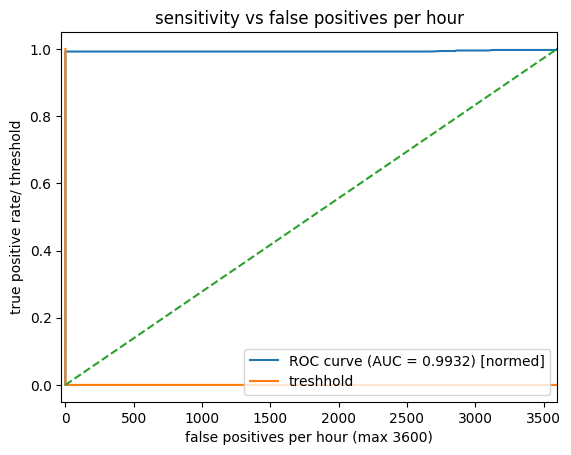

In [10]:
# plot modified AUC
thresholds[thresholds>1] = 1
plt.plot(np.array(results.mean_spikes_per_hour),tpr,label='ROC curve (AUC = %0.4f) [normed]' % roc_auc)
plt.plot(np.array(results.mean_spikes_per_hour),thresholds,label='treshhold')
plt.plot([0, max(results.mean_spikes_per_hour)], [0, 1], linestyle='--')
plt.xlabel('false positives per hour (max 3600)')
plt.legend(loc="lower right")
plt.xlim(-30,3600)
plt.ylabel('true positive rate/ threshold')
plt.title('sensitivity vs false positives per hour')
plt.savefig(path_model+'/Results/modified_AUC.png')

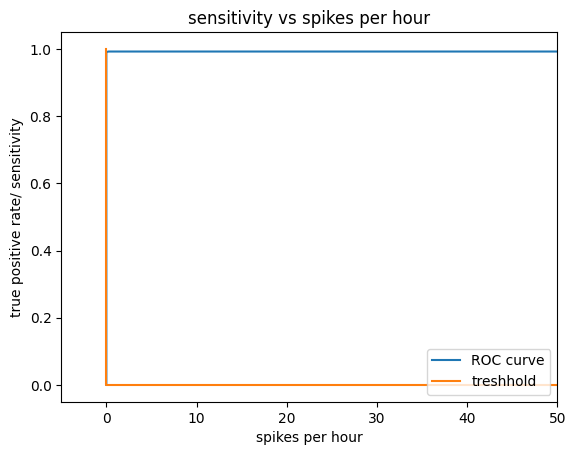

In [11]:
# plot zoomed in version of modified AUC
plt.plot(np.array(results.mean_spikes_per_hour),tpr,label='ROC curve')
plt.plot(np.array(results.mean_spikes_per_hour),thresholds,label='treshhold')
plt.xlabel('spikes per hour')
plt.legend(loc="lower right")
plt.ylabel('true positive rate/ sensitivity')
plt.title('sensitivity vs spikes per hour')
plt.xlim(-5,50)
plt.savefig(path_model+'/Results/modified_AUC_ZOOM.png')


In [12]:
# write brier score to text file
with open(path_model+'/Results/results.txt', 'a') as f:
    f.write('Modified AUC: '+str(roc_auc)+'\n')